本次任务可以直接跳到第27单元格，缺失值在上一任务已经基本完成，直接进行异常检测,主要是area，按baseline的参数训练，结果一晚上没跑出结果，应该需要检查一下哪里出了问题是。这次时间比较赶，未完成的深度清洗在task3中进行

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="darkgrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_a.csv')
print(train.shape)
print(test.shape)

(41440, 51)
(2469, 50)


In [3]:
target = 'tradeMoney'
test[target] = -1
data = pd.concat([train,test])

In [4]:
columns = data.columns.tolist()
columns.remove(target)
object_col = ['buildYear','city','communityName','houseDecoration','houseFloor','houseToward','houseType',
             'plate','region','rentType','tradeTime'] # object型特征
num_col = [x for x in columns if x not in object_col] # 数值型特征

In [5]:
data[object_col].head() # 把暂无信息,其他,暂无数据,未知方式也当做缺失，放到后面处理

,buildYear,city,communityName,houseDecoration,houseFloor,houseToward,houseType,plate,region,rentType,tradeTime
0,1953,SH,XQ00051,其他,低,暂无数据,2室1厅1卫,BK00064,RG00001,未知方式,2018/11/28
1,2007,SH,XQ00130,简装,中,暂无数据,3室2厅2卫,BK00049,RG00002,未知方式,2018/12/16
2,暂无信息,SH,XQ00179,其他,低,暂无数据,3室2厅2卫,BK00050,RG00002,未知方式,2018/12/22
3,暂无信息,SH,XQ00313,精装,中,暂无数据,1室1厅1卫,BK00051,RG00002,未知方式,2018/12/21
4,暂无信息,SH,XQ01257,毛坯,低,暂无数据,3室2厅3卫,BK00044,RG00003,未知方式,2018/11/18


In [6]:
train.nunique().sort_values()

city                      1
houseFloor                3
supplyLandNum             4
rentType                  4
houseDecoration           4
tradeLandNum              5
interSchoolNum            7
houseToward              10
hospitalNum              11
subwayStationNum         13
region                   15
privateSchoolNum         17
mallNum                  17
parkNum                  18
saleSecHouseNum          28
lookNum                  32
gymNum                   39
drugStoreNum             42
schoolNum                44
bankNum                  45
tradeLandArea            46
landTotalPrice           46
superMarketNum           49
landMeanPrice            52
supplyLandArea           54
totalFloor               55
shopNum                  56
busStationNum            59
totalWorkers             63
residentPopulation       63
plate                    66
buildYear                80
supplyNewNum            104
houseType               104
tradeNewNum             157
newWorkers          

Label分布

In [7]:
train[target].describe() # 最大值1亿应该属于异常

count    4.144000e+04
mean     8.837074e+03
std      5.514287e+05
min      0.000000e+00
25%      2.800000e+03
50%      4.000000e+03
75%      5.500000e+03
max      1.000000e+08
Name: tradeMoney, dtype: float64

In [8]:
# 把月租金大于5w的样本去除
train = train[train[target]<50000]
data = data[data[target]<50000]

缺失值

In [9]:
for i in range(data[columns].shape[1]):
    lost = data[columns].iloc[:,i].isnull().sum()
    if lost>0:
        print(columns[i],':',lost)

pv : 20
uv : 20


In [10]:
# 使用均值填充
data['pv'] = data['pv'].fillna(data['pv'].mean())
data['uv'] = data['uv'].fillna(data['uv'].mean())

对buildYear,houseDecoration,houseToward,rentType分别查看

In [11]:
'''buildYear'''
# 如果只存在训练集中，想把这部分样本删除，但是测试集也有就只能填上
# 看一眼分布，决定用中位数填上
print(train[train['buildYear'] == '暂无信息'] .shape)
print(test[test['buildYear'] == '暂无信息'] .shape)
# sns.distplot(train[train['buildYear'] == '暂无信息'][target], bins=20)

(2804, 51)
(128, 51)


In [12]:
median_year = data[data['buildYear'] != '暂无信息']['buildYear'].median()
print(median_year)
data['buildYear'][data['buildYear'] == '暂无信息'] = median_year
data['buildYear'] = data['buildYear'].astype(int)
object_col.remove('buildYear')

2002.0


In [13]:
'''houseDecoration'''
# '其他'的比例太高了，简装和精装的区别也不明显，考虑将该特征删除
print(train['houseDecoration'].value_counts())
print(test['houseDecoration'].value_counts())
from matplotlib.font_manager import FontProperties  
%matplotlib inline
font = FontProperties(fname="/notebooks/simhei.ttc", size=14) 

# for i in train['houseDecoration'].unique():
#     sns.distplot(train[train['houseDecoration']==i][target], bins=20)
#     plt.title(i,fontproperties=font)
#     plt.show()

其他    28991
精装    10899
简装     1169
毛坯      311
Name: houseDecoration, dtype: int64
其他    1981
精装     370
简装     102
毛坯      16
Name: houseDecoration, dtype: int64


In [14]:
columns.remove('houseDecoration')
object_col.remove('houseDecoration')

In [15]:
'''houseToward'''
# 常识来讲东南朝向比西北好，但似乎和图上显示的有一些差距
# 测试集中的'暂无数据占了近50%'，且未出现朝北的数据，考虑尝试把‘暂无数据’以‘北’替换
print(train['houseToward'].value_counts())
print(test['houseToward'].value_counts())

# for i in train['houseToward'].unique():
#     sns.distplot(train[train['houseToward']==i][target], bins=20)
#     plt.xlim(0,50000)
#     plt.title(i,fontproperties=font)
#     plt.show()

南       34327
南北       2251
北        2041
暂无数据      955
东南        655
东         550
西         262
西南        248
西北         57
东西         24
Name: houseToward, dtype: int64
暂无数据    1173
南        666
南北       530
西南        73
西北        12
西         11
东南         3
东          1
Name: houseToward, dtype: int64


In [16]:
data['houseToward'][data['houseToward']=='暂无数据'] = '南'

In [17]:
'''租赁方式'''
print(data['rentType'].value_counts())
# for i in train['rentType'].unique():
#     sns.distplot(train[train['rentType']==i][target], bins=20)
#     plt.xlim(0,50000)
#     plt.title(i,fontproperties=font)
#     plt.show()

未知方式    32888
整租       5722
合租       5224
--          5
Name: rentType, dtype: int64


In [18]:
# 缺失也很严重，考虑丢弃该特征
print(train[train['rentType'] == '--'] .shape)
print(test[test['rentType'] == '--'] .shape)
print(train[train['rentType'] == '未知方式'] .shape)
print(test[test['rentType'] == '未知方式'] .shape)
columns.remove('rentType')
object_col.remove('rentType')

(5, 51)
(0, 51)
(30703, 51)
(2185, 51)


不同取值个数，可以区分离散特征还是连续特征

In [19]:
nuniq = pd.DataFrame()
nuniq['feature'] = columns
nuniq['num'] = data[columns].nunique().values
print(nuniq)

               feature    num
0                   ID  43839
1                 area  10544
2            houseType    102
3           houseFloor      3
4           totalFloor     54
5          houseToward      9
6        communityName   4221
7                 city      1
8               region     15
9                plate     66
10           buildYear     79
11     saleSecHouseNum     28
12    subwayStationNum     13
13       busStationNum     59
14      interSchoolNum      7
15           schoolNum     44
16    privateSchoolNum     17
17         hospitalNum     11
18        drugStoreNum     42
19              gymNum     39
20             bankNum     45
21             shopNum     56
22             parkNum     18
23             mallNum     17
24      superMarketNum     49
25     totalTradeMoney    706
26      totalTradeArea    707
27      tradeMeanPrice    707
28         tradeSecNum    334
29  totalNewTradeMoney    561
30   totalNewTradeArea    535
31   tradeNewMeanPrice    560
32        

In [20]:
nuniq.set_index('feature',drop=True,inplace=True)
nuniq.loc[object_col] 

,num
feature,
city,1
communityName,4221
houseFloor,3
houseToward,9
houseType,102
plate,66
region,15
tradeTime,361


结合nunique值，对字符类型的特征编码

In [21]:
data['room'] = data['houseType'].apply(lambda x : x.split('室')[0][-1]).astype(int)
data['living'] = data['houseType'].apply(lambda x : x.split('厅')[0][-1]).astype(int)
data['toilet'] = data['houseType'].apply(lambda x : x.split('卫')[0][-1]).astype(int)
columns.remove('houseType')
columns.extend(['room','living','toilet'])
object_col.remove('houseType')

In [22]:
data['tradeYear'] = data['tradeTime'].apply(lambda x : x.split('/')[0]).astype(int)
data['tradeMonth'] = data['tradeTime'].apply(lambda x : x.split('/')[1]).astype(int)
data['tradeDate'] = data['tradeTime'].apply(lambda x : x.split('/')[2]).astype(int)
columns.remove('tradeTime')
columns.extend(['tradeYear','tradeMonth','tradeDate'])
object_col.remove('tradeTime')

In [23]:
from sklearn.preprocessing import LabelEncoder
for i in object_col:
    lbl = LabelEncoder()
    data[i] = lbl.fit_transform(data[i])

In [24]:
# 删除ID，定值列
columns.remove('ID')
columns.remove('city')
columns.remove('tradeYear')
len(columns)

49

训练集和测试集的特征分布对比,如果有明显差异需重新采样训练集

In [25]:
data.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,uv,lookNum,tradeTime,tradeMoney,room,living,toilet,tradeYear,tradeMonth,tradeDate
0,100309852,68.06,未知方式,2室1厅1卫,1,16,4,其他,50,0,...,284.0,0,2018/11/28,2000.0,2,1,1,2018,11,28
1,100307942,125.55,未知方式,3室2厅2卫,0,14,4,简装,128,0,...,22.0,1,2018/12/16,2000.0,3,2,2,2018,12,16
2,100307764,132.00,未知方式,3室2厅2卫,1,32,4,其他,177,0,...,20.0,1,2018/12/22,16000.0,3,2,2,2018,12,22
3,100306518,57.00,未知方式,1室1厅1卫,0,17,4,精装,311,0,...,279.0,9,2018/12/21,1600.0,1,1,1,2018,12,21
4,100305262,129.00,未知方式,3室2厅3卫,1,2,4,毛坯,1248,0,...,480.0,0,2018/11/18,2900.0,3,2,3,2018,11,18


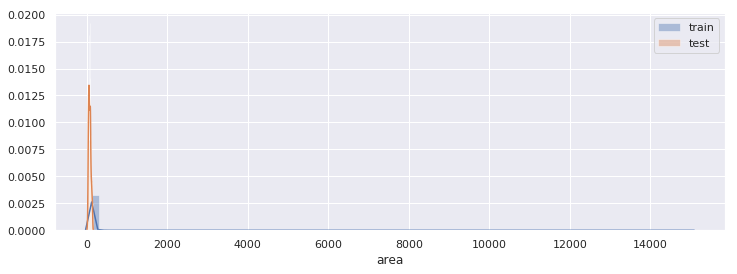

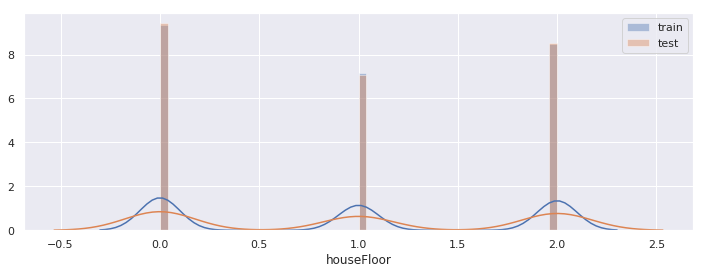

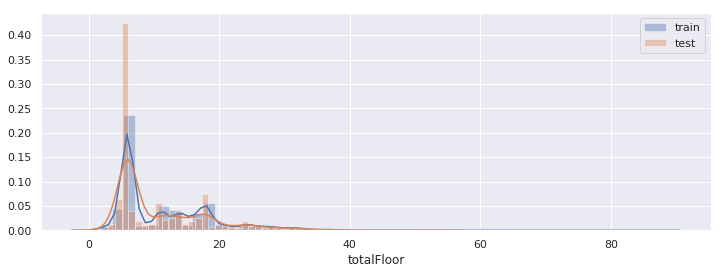

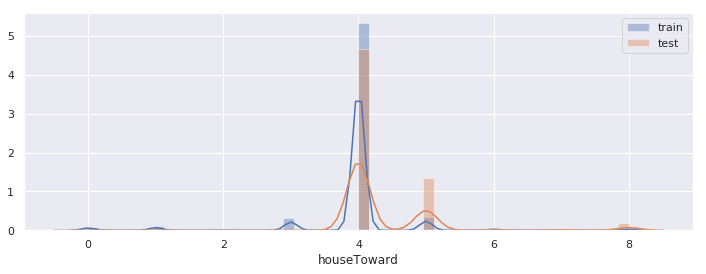

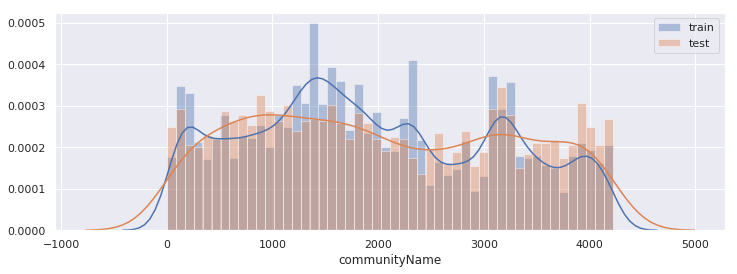

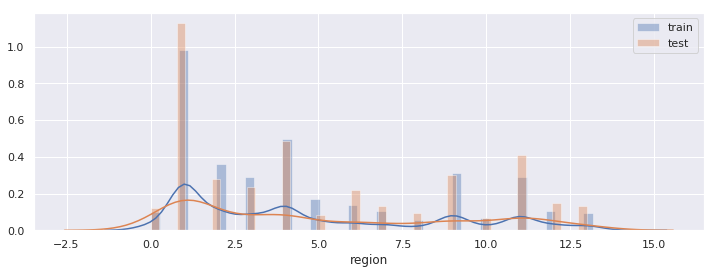

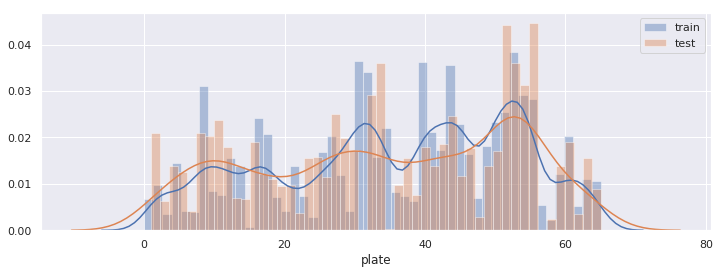

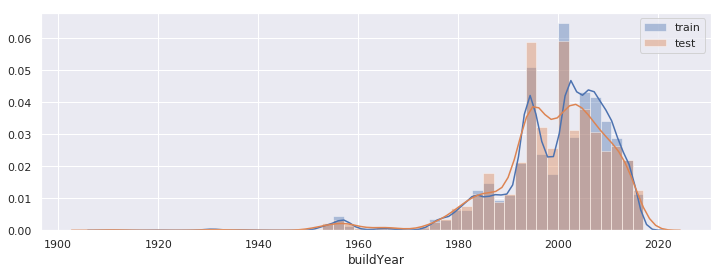

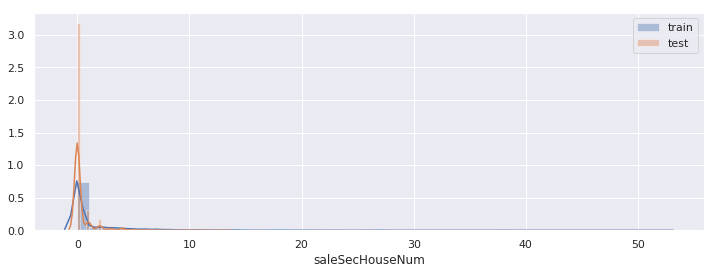

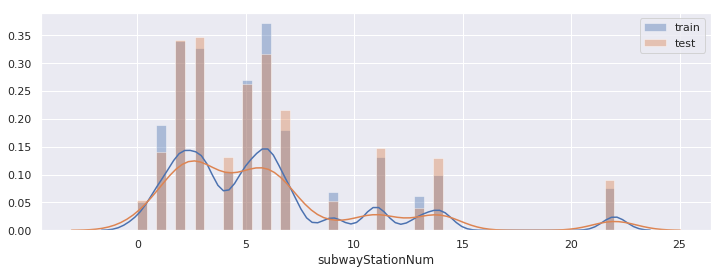

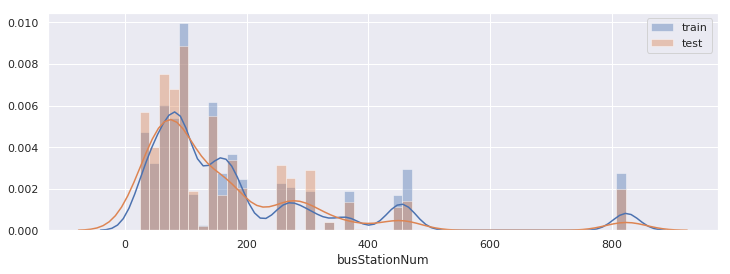

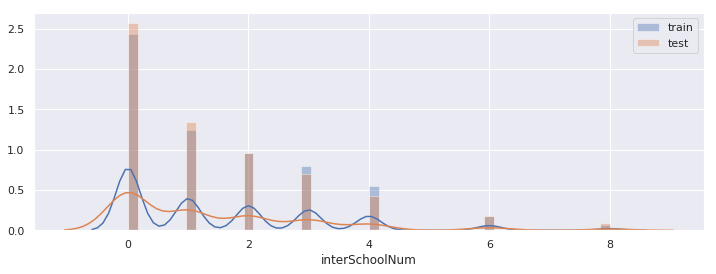

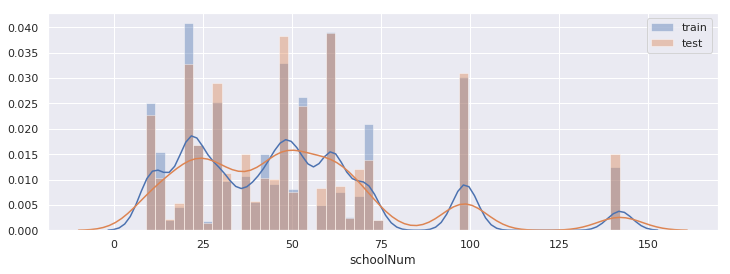

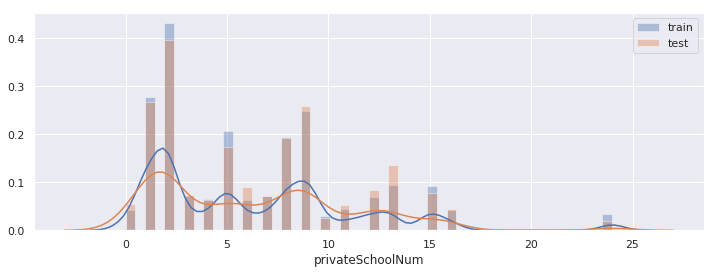

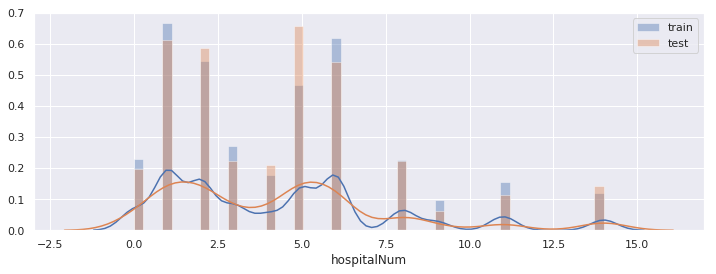

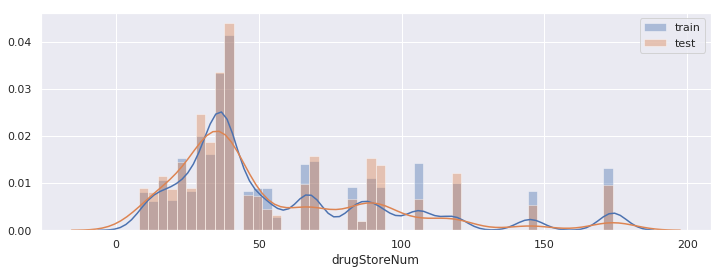

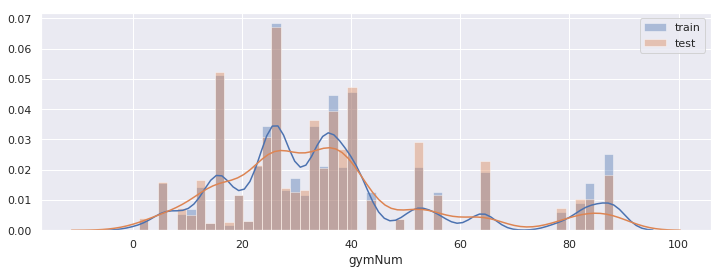

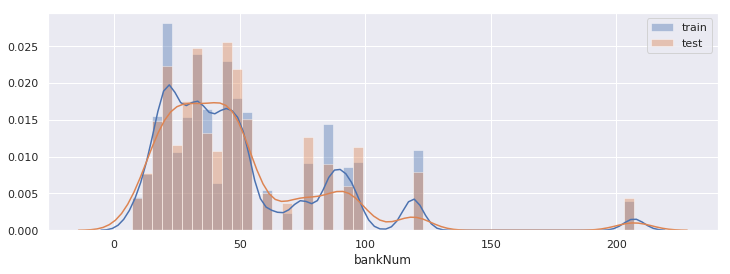

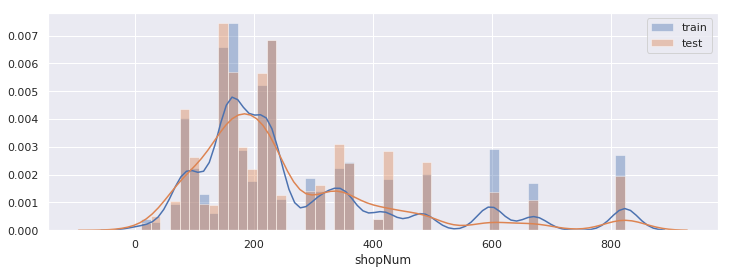

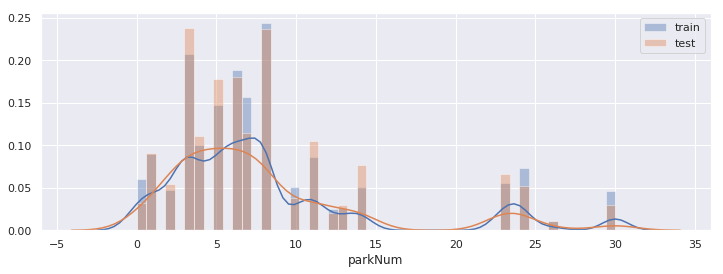

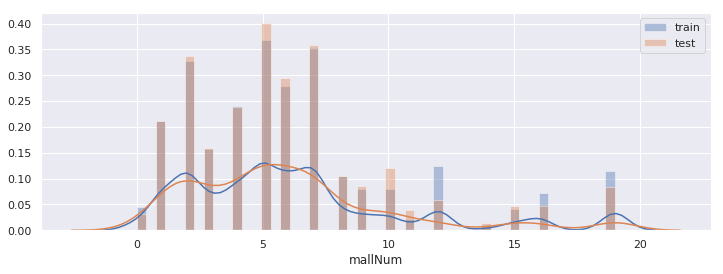

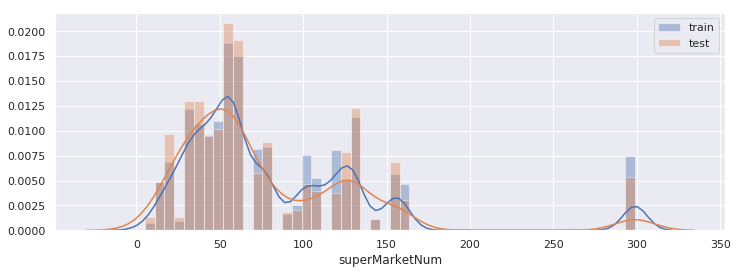

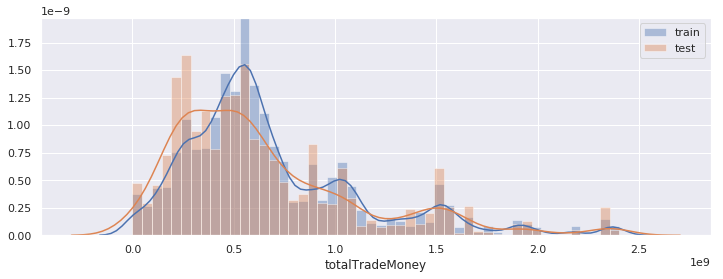

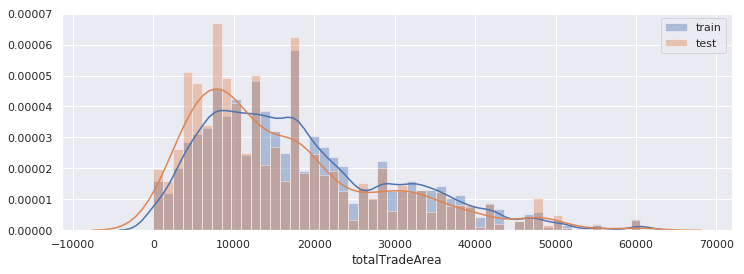

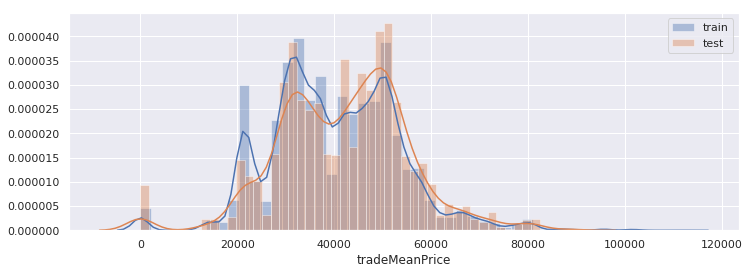

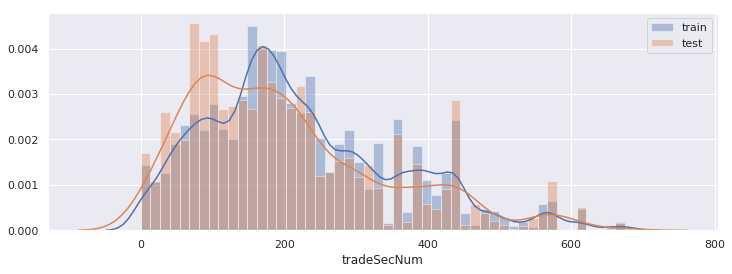

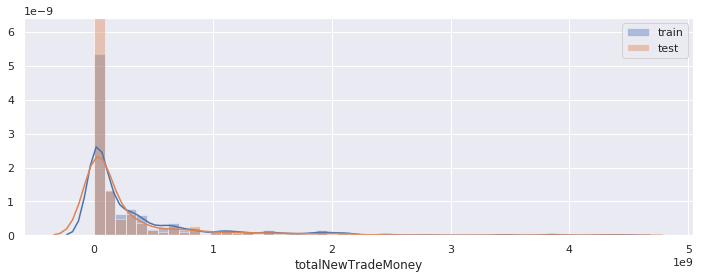

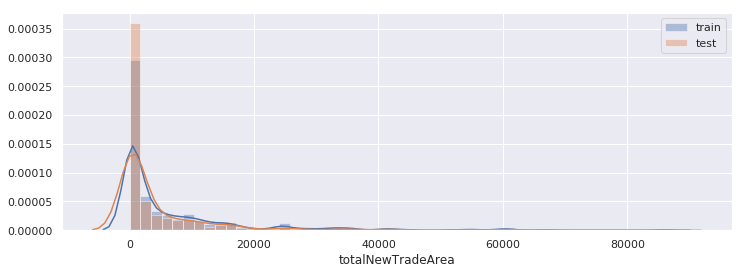

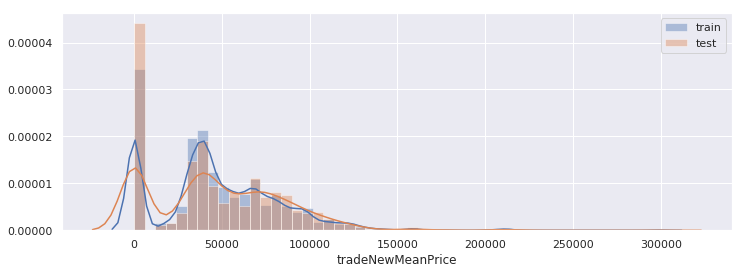

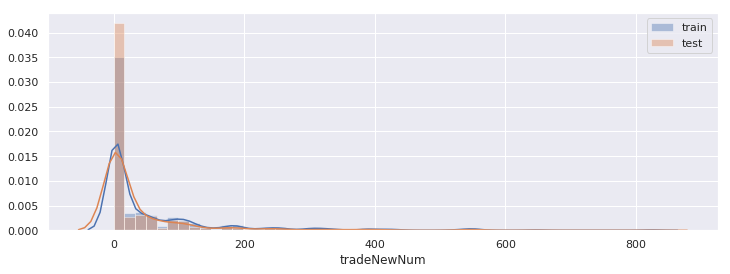

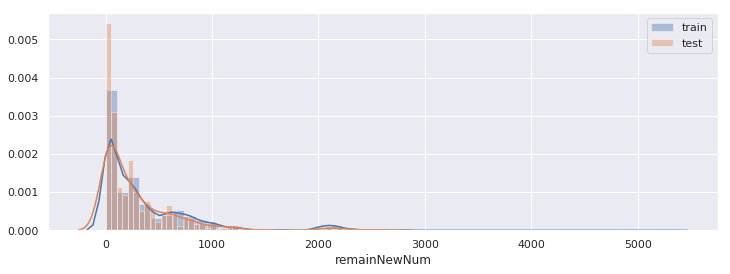

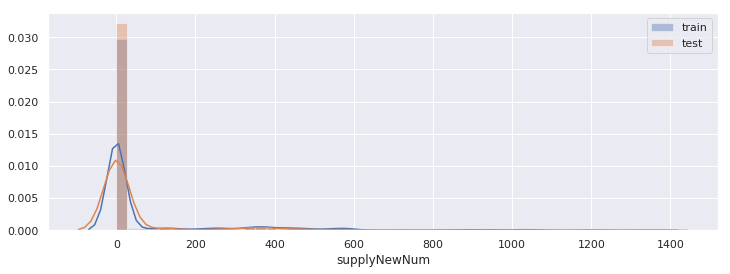

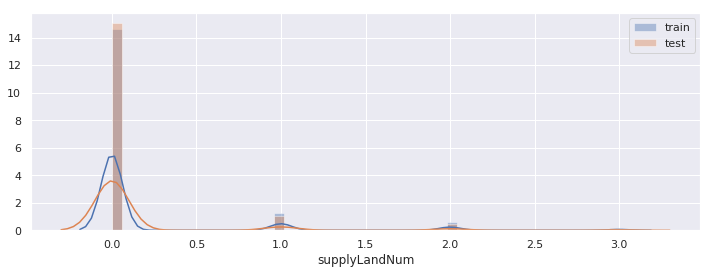

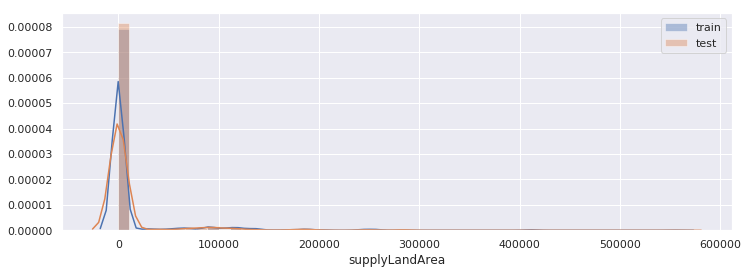

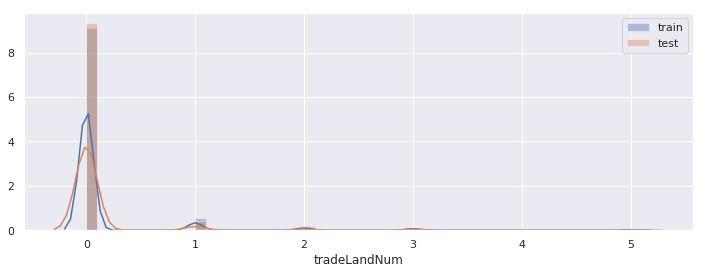

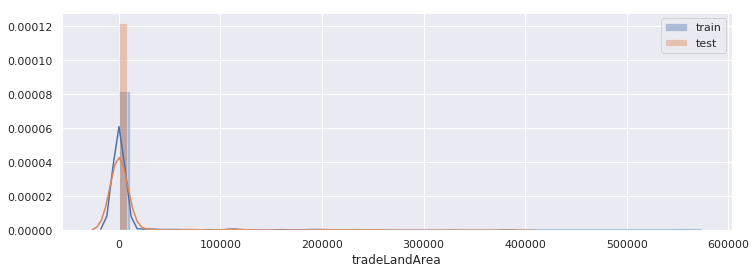

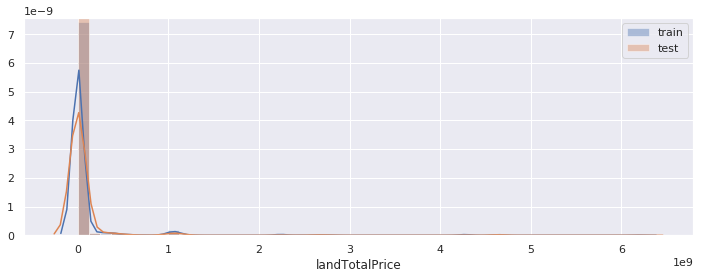

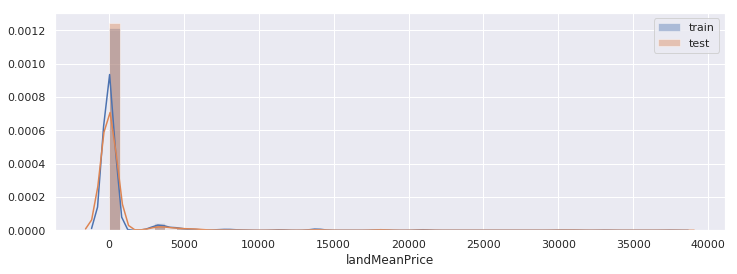

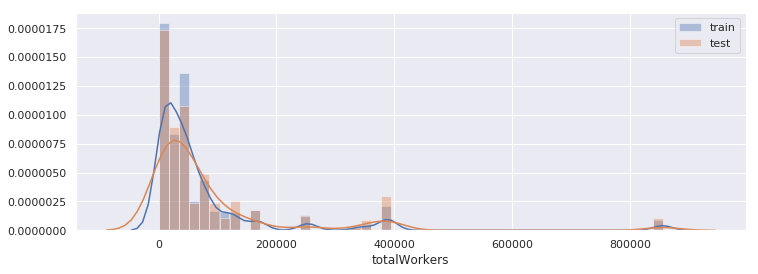

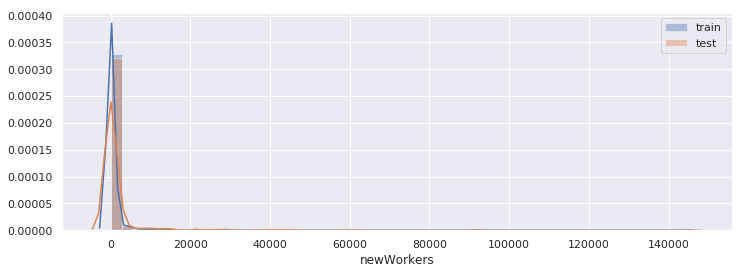

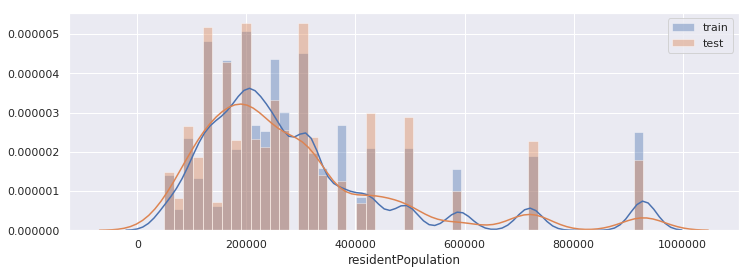

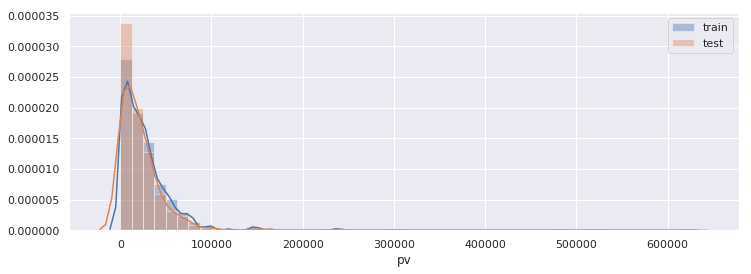

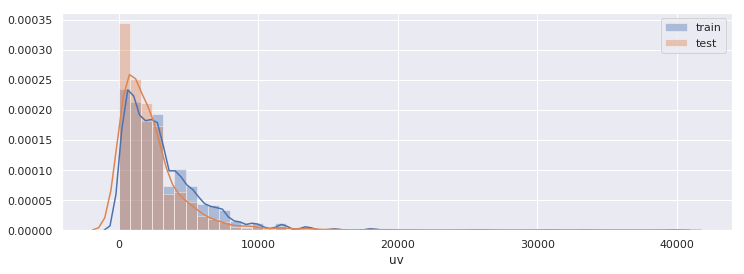

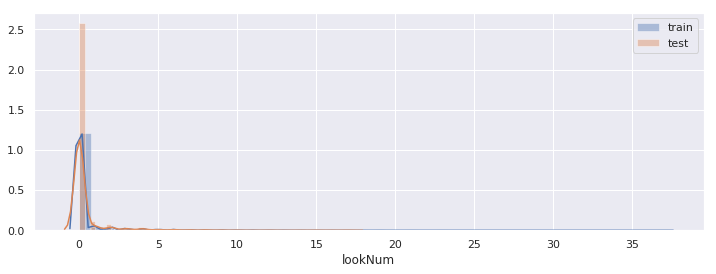

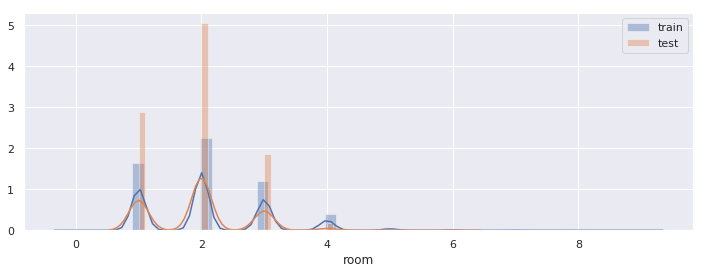

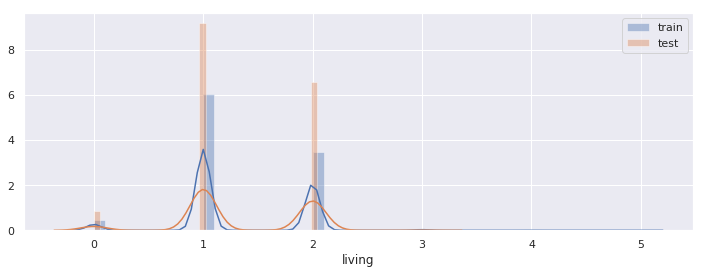

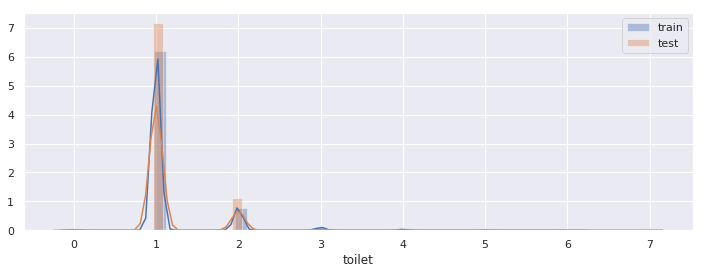

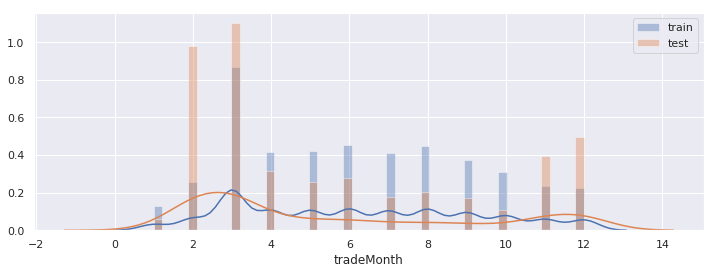

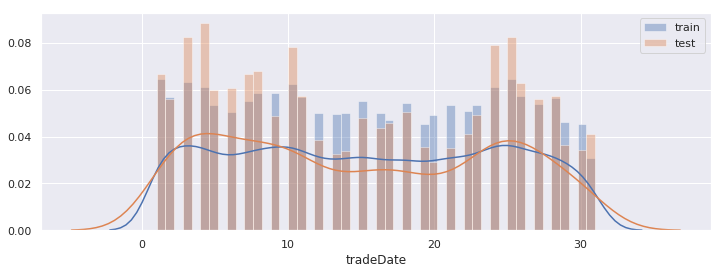

In [26]:
train = data[data[target] != -1]
test = data[data[target] == -1]
for i,col in enumerate(columns):
    plt.figure(figsize=(12,4))
    sns.distplot(train[col], bins=50)
    sns.distplot(test[col], bins=50) 
    plt.legend(['train','test'])

异常处理，主要针对area

In [27]:
print(train['area'].describe())
print(test['area'].describe())

count    41370.000000
mean        70.538372
std         87.161926
min          1.000000
25%         42.560000
50%         64.980000
75%         90.000000
max      15055.000000
Name: area, dtype: float64
count    2469.000000
mean       76.031839
std        29.080334
min        15.000000
25%        53.000000
50%        73.160000
75%        94.320000
max       150.000000
Name: area, dtype: float64


In [28]:
# 测试集的面积最大值只有150,最小值15，而训练集为15055和1，取训练集10-200部分
train = train[train['area'] < 200]
train = train[train['area'] > 10]

In [ ]:
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train[columns],train[target], test_size=0.3, random_state=666)
lgb_model = lgb.LGBMRegressor(boosting_type="gbdt", objective='regression',metric='mse')
lgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train),(X_test, y_test)],
              early_stopping_rounds=10)

[1]	training's l2: 8.35183e+06	valid_1's l2: 7.91401e+06
Training until validation scores don't improve for 10 rounds.
[2]	training's l2: 7.222e+06	valid_1's l2: 6.83082e+06
[3]	training's l2: 6.29514e+06	valid_1's l2: 5.94273e+06
[4]	training's l2: 5.54367e+06	valid_1's l2: 5.23703e+06
[5]	training's l2: 4.91486e+06	valid_1's l2: 4.64922e+06
[6]	training's l2: 4.38072e+06	valid_1's l2: 4.15203e+06
[7]	training's l2: 3.92658e+06	valid_1's l2: 3.73284e+06
[8]	training's l2: 3.56254e+06	valid_1's l2: 3.38454e+06
[9]	training's l2: 3.2484e+06	valid_1's l2: 3.09521e+06
[10]	training's l2: 2.97948e+06	valid_1's l2: 2.84983e+06
[11]	training's l2: 2.75105e+06	valid_1's l2: 2.64921e+06
[12]	training's l2: 2.56634e+06	valid_1's l2: 2.48231e+06
[13]	training's l2: 2.40092e+06	valid_1's l2: 2.32652e+06
[14]	training's l2: 2.26021e+06	valid_1's l2: 2.19799e+06
[15]	training's l2: 2.13713e+06	valid_1's l2: 2.08191e+06
[16]	training's l2: 2.03631e+06	valid_1's l2: 1.99255e+06
[17]	training's l2: 1.

#### 评估

In [33]:
eval_data = pd.read_csv('./data/评分文件/sub_a_913.csv')
pred_eval = lgb_model.predict(test[columns])
r2_score(eval_data['pre'],pred_eval)

0.9068947868996167

5折结果跑了一晚上没出来，只能先没调参的一折结果提交了，结果反而下降了 =_=